In [1]:
# Data Wrangling libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import pickle
import missingno
from collections import Counter

# Machine learning models libraries
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation library
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning library
from sklearn.model_selection import GridSearchCV

# Remove warnings library
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Access data from Data dir.
data_path = 'Data/'
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
ss = pd.read_csv("Data/gender_submission.csv")

In [3]:
data_type = {
    'PassengerId': str,
    'Survived': bool,
    'Pclass': 'category', # Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
    'Name': str,
    'Sex': 'category',
    'Age': float,
    'SibSp': 'uint8', # number of siblings/spouses aboard
    'Parch': 'uint8', # number of parents/children aboard
    'Ticket': str, # Ticket number
    'Fare': float, # Passenger fare
    'Cabin': str, # Cabin number
    'Embarked': 'category'} # Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

# load and serialize dataframes for later use in preprocessing notebook
for ds_name in ['test', 'train']: # last one is used in this document
    df = pd.read_csv(data_path+ds_name+'.csv', dtype=data_type)
    with open(data_path+ds_name+'_dv.obj', 'wb') as file:
        pickle.dump(df, file)

In [4]:
#view the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


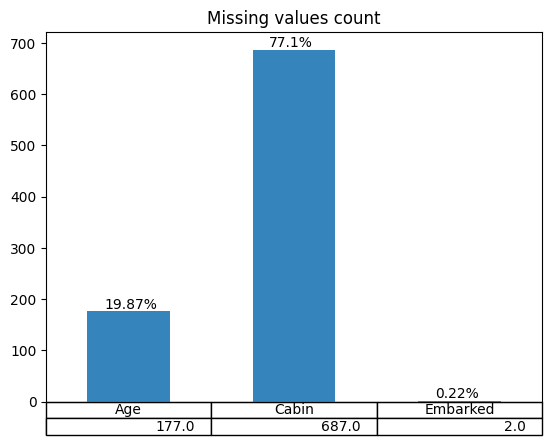

In [5]:
# Missing values

# number of rows
rows_length = df.shape[0]
# fields with missing value count
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind='bar', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels


# write percentage on top of each bar
for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

In [6]:
# some statistics about the numerical data
df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [8]:
ss.describe()

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.363636
std,120.810458,0.481622
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


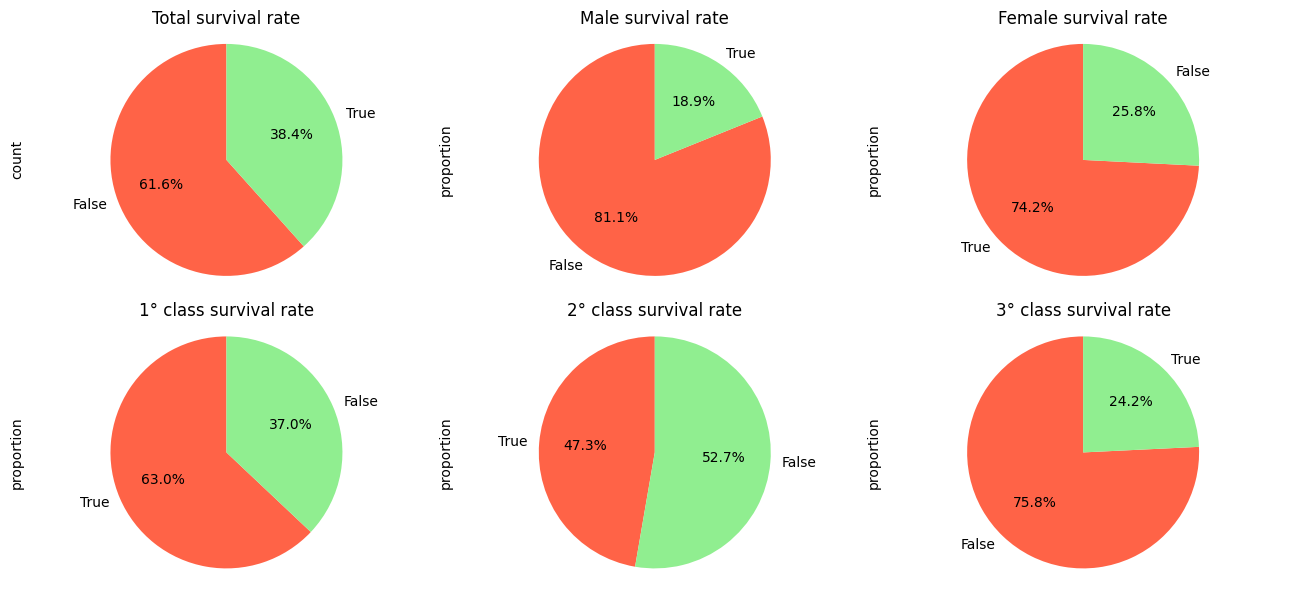

In [11]:
# Specifies the parameters of our graphs
plt.figure(figsize=(13,6))
plot_params = {
    'kind': 'pie',
    'startangle': 90,
    'autopct': '%1.1f%%',
    'colors': ['tomato', 'lightgreen']
}


# Plots a bar graph of those who surived vs those who did not
plt.subplot2grid((2,3), (0,0))
df.Survived.value_counts() \
.plot(title='Total survival rate', **plot_params).axis('equal')


# Survival rate wrt Sex
df_male = df.Survived[df.Sex == 'male'].value_counts(normalize=True, sort=False)
df_female = df.Survived[df.Sex == 'female'].value_counts(normalize=True, sort=False)

## male survival plot
plt.subplot2grid((2,3),(0,1))
df_male.plot(title='Male survival rate', **plot_params).axis('equal')

## female survival plot
plt.subplot2grid((2,3),(0,2))
df_female.plot(title='Female survival rate', **plot_params).axis('equal')


# Survival rate wrt Pclass
for i in range(3):
    plt.subplot2grid((2,3),(1,i))
    df.Survived[df.Pclass == str(i+1)].value_counts(normalize=True, sort=False) \
    .plot(title=str(i+1)+'° class survival rate', **plot_params).axis('equal')


plt.tight_layout()
plt.show()

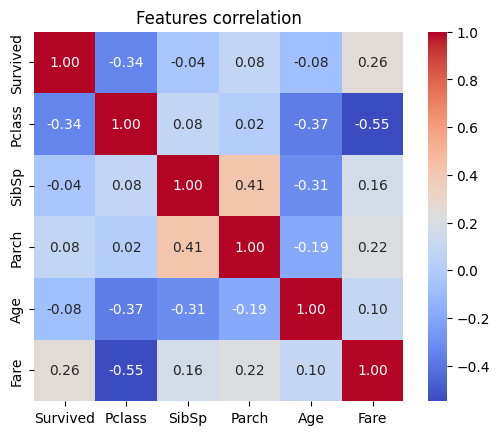

In [12]:
#Correlation between features
sns.heatmap(df[['Survived','Pclass', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),square=True, annot = True, fmt = '.2f', cmap = 'coolwarm').set_title('Features correlation');

In [13]:
# Value counts of the male and female
train['Sex'].value_counts(dropna = False)

Sex
male      577
female    314
Name: count, dtype: int64

In [14]:
# Mean of survival by male and female
train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0.5, 1.0, 'Survival Probability by Gender')

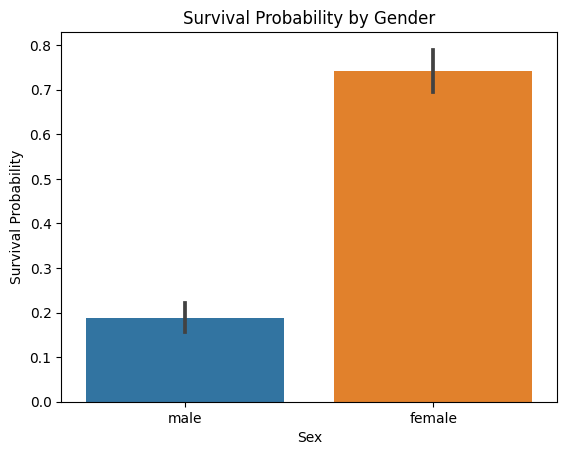

In [15]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

# Female passengers are more likely to survive

In [16]:
# Value counts of the Pclass column 
train['Pclass'].value_counts(dropna = False)

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [17]:
# Mean of survival by passenger class
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Survival Probability by Passenger Class')

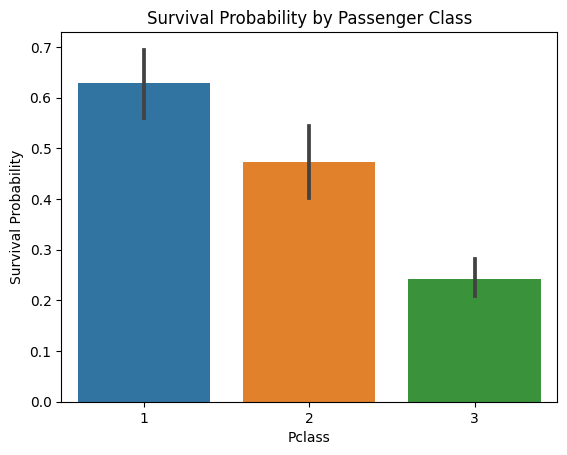

In [18]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Passenger Class')

# Survival probability decrease with passenger class, first class passengers are prioritised during evacuation

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

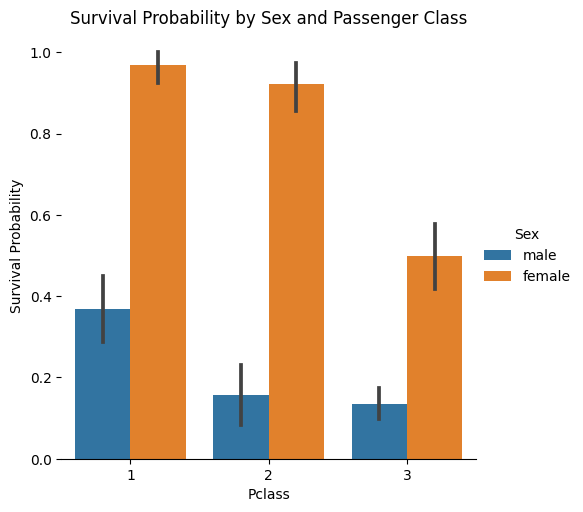

In [19]:
# Survival by gender and passenger class

g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

In [20]:
# Value counts of the Embarked column 

train['Embarked'].value_counts(dropna = False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [21]:
# Mean of survival by point of embarkation

train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

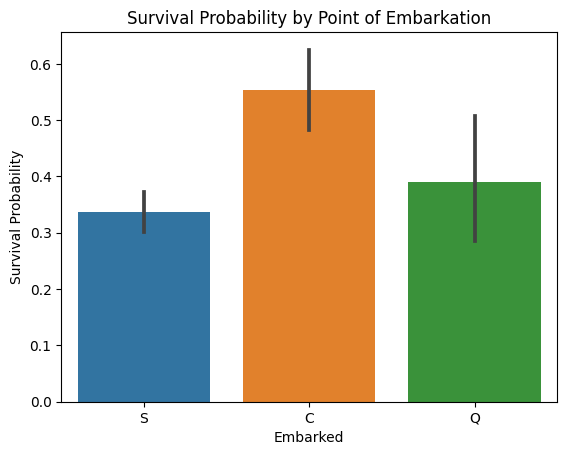

In [22]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

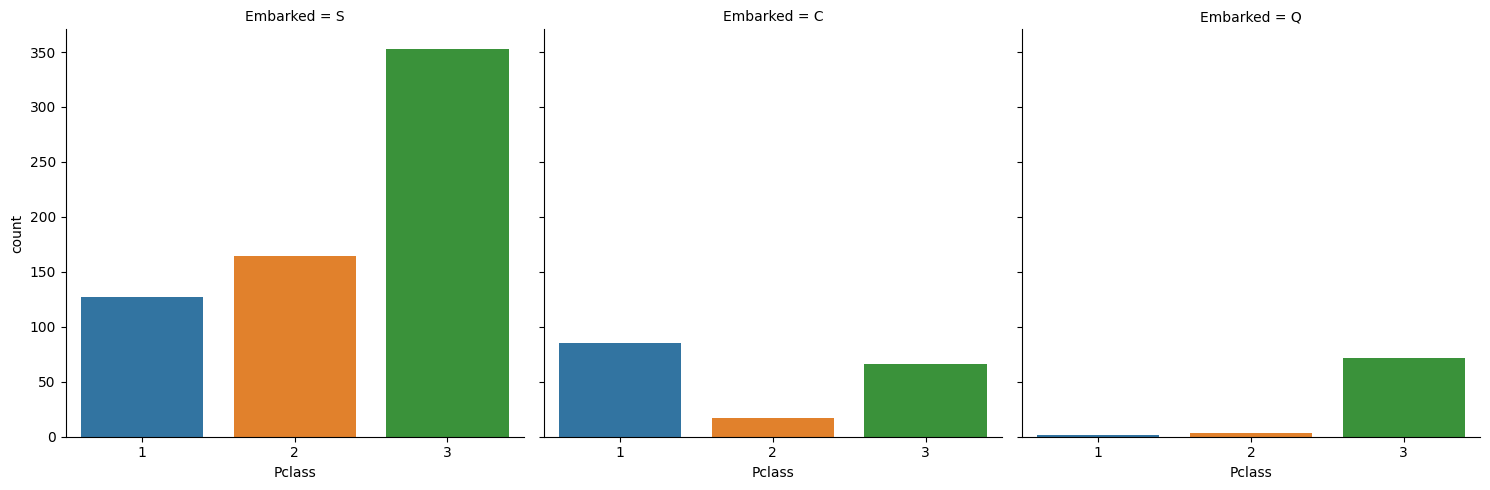

In [23]:
g = sns.catplot(x = 'Pclass', col = 'Embarked' , data = train, kind = 'count')

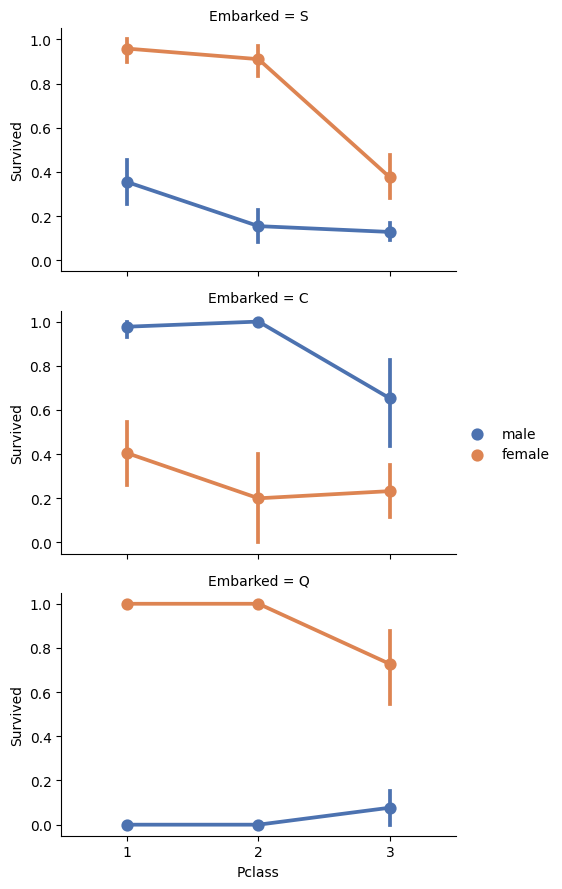

In [24]:
# Survival probability by all categorical variables

grid = sns.FacetGrid(train, row = 'Embarked', aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

In [25]:
def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 10 indices:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [26]:
train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [27]:
# Drop outliers and reset index

print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


<Axes: >

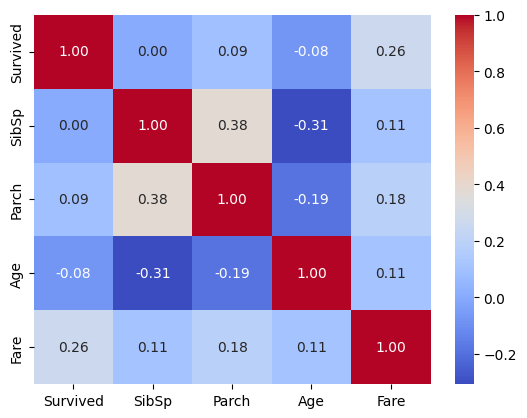

In [28]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

In [29]:
# Value counts of the SibSp column 

train['SibSp'].value_counts(dropna = False)

SibSp
0    608
1    209
2     28
4     18
3     13
5      5
Name: count, dtype: int64

In [30]:
# Mean of survival by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Text(0.5, 1.0, 'Survival Probability by SibSp')

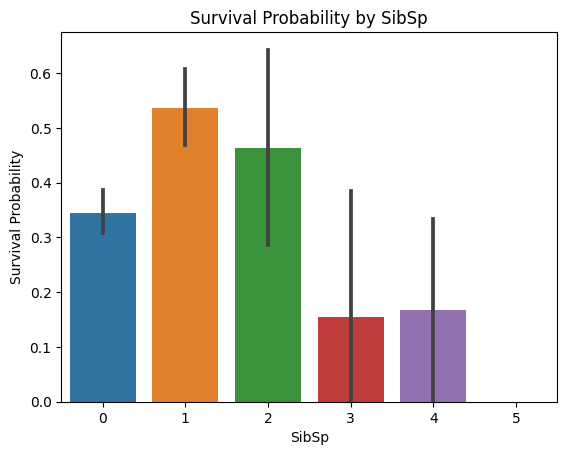

In [31]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

In [32]:
# Value counts of the Parch column 

train['Parch'].value_counts(dropna = False)

Parch
0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [33]:
# Mean of survival by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Text(0.5, 1.0, 'Survival Probability by Parch')

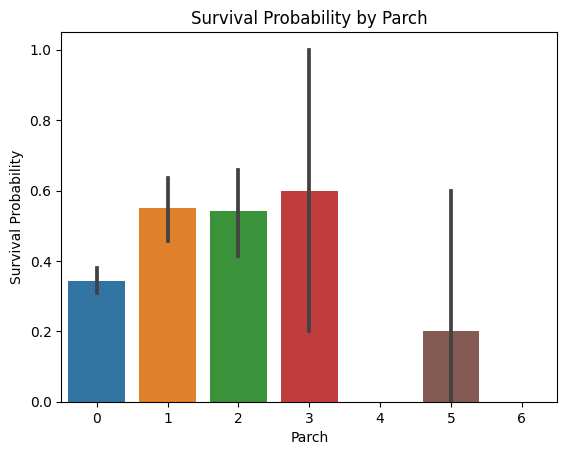

In [34]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

In [35]:
# Null values in Age column 

train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

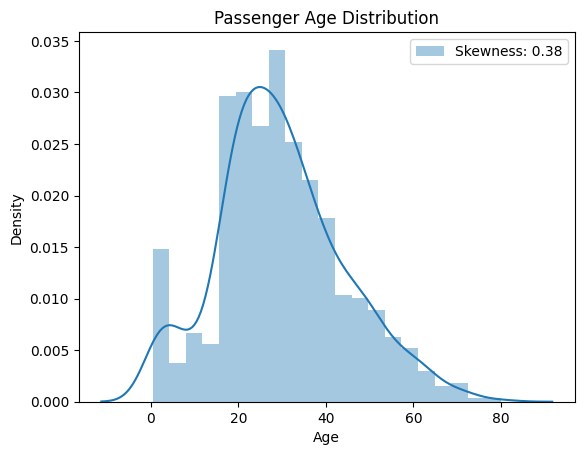

In [36]:
# Passenger age distribution

sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

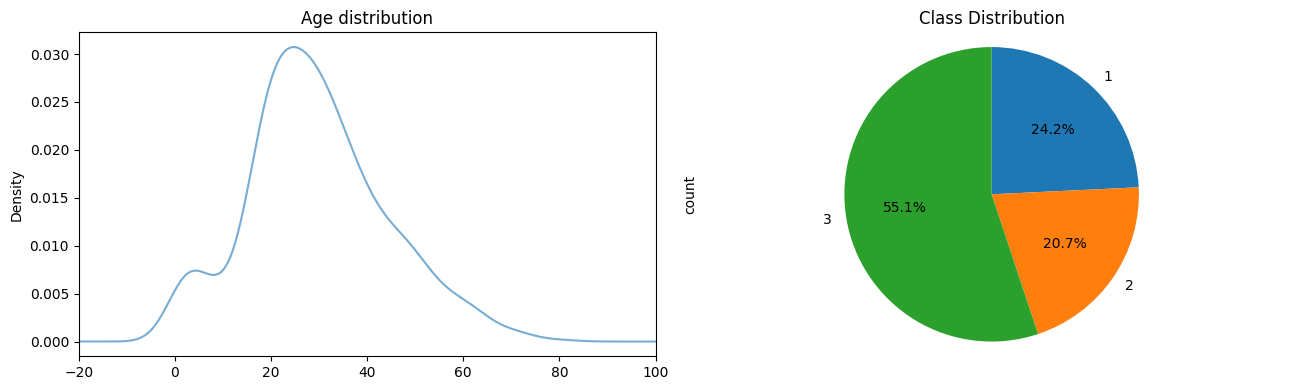

In [37]:
plt.figure(figsize=(13,4))

# plots a bar graph of the age distribution
plt.subplot2grid((1,2), (0,0))
df.Age.plot(kind='kde', alpha=0.6, title='Age distribution', xlim=(-20, 100))

# plots a bar graph of the class distribution
plt.subplot2grid((1,2),(0,1))
df.Pclass.value_counts(sort=False).plot(kind='pie', title='Class Distribution', \
                                        autopct='%1.1f%%', counterclock=False, \
                                        startangle=90).axis('equal')

plt.tight_layout()
plt.show()

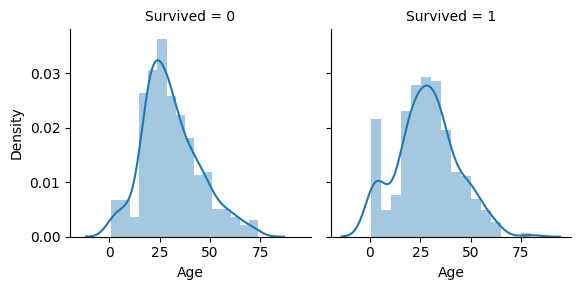

In [38]:
# Age distribution by survival

g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

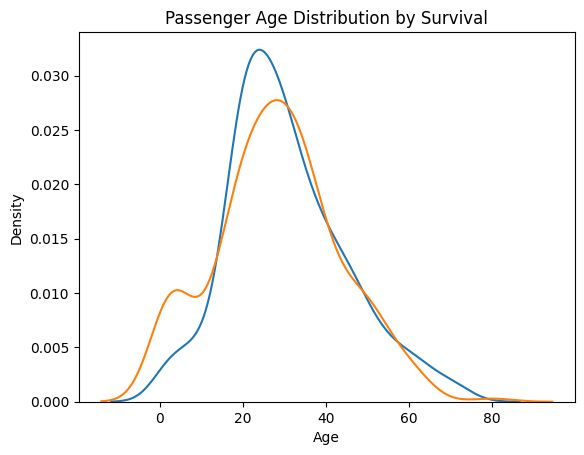

In [39]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

In [40]:
# Null values of Fare column 

train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Fare Distribution')

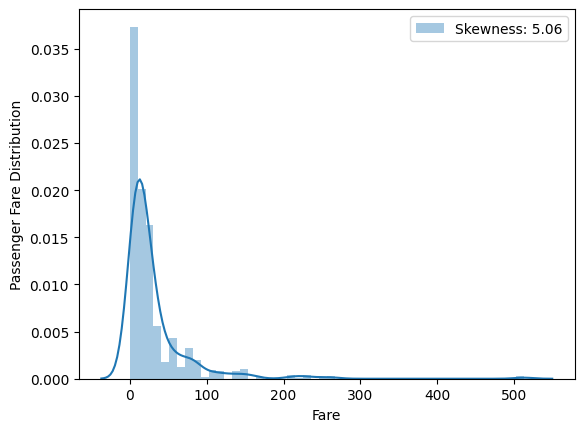

In [41]:
# Passenger fare distribution

sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

In [42]:
# Drop ticket and cabin features from training and test set
train = train.drop(['Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)

In [43]:
# Missing values in training set 

train.isnull().sum().sort_values(ascending = False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [44]:
# Compute the most frequent value of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [45]:
# Fill missing value in Embarked with mode

train['Embarked'].fillna(mode, inplace = True)

In [46]:
# Missing values in test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [47]:
# Compute median of Fare in test set 

median = test['Fare'].dropna().median()
median

14.4542

In [48]:
# Fill missing value in Fare with median

test['Fare'].fillna(median, inplace = True)

In [49]:
# Combine training set and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [50]:
# Missing values in the combined dataset

combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [51]:
# Convert Sex into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

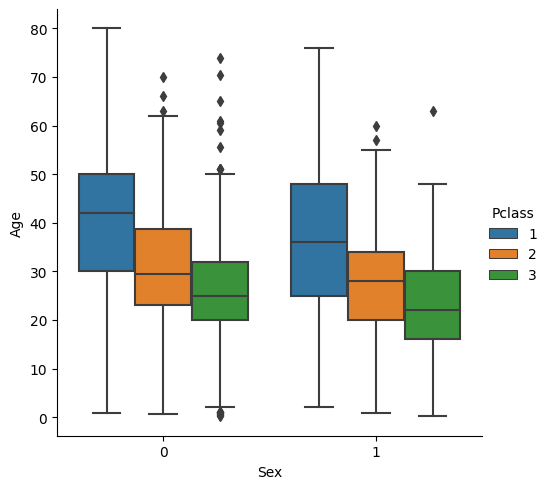

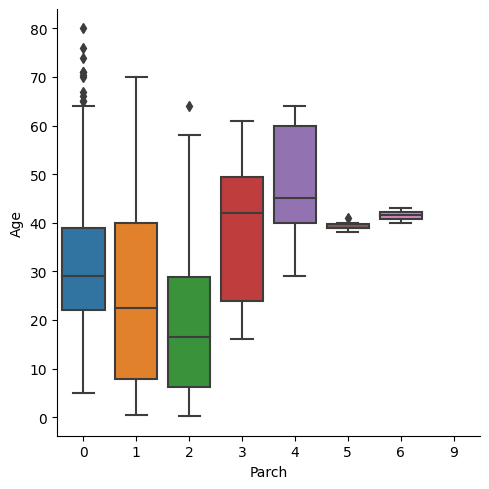

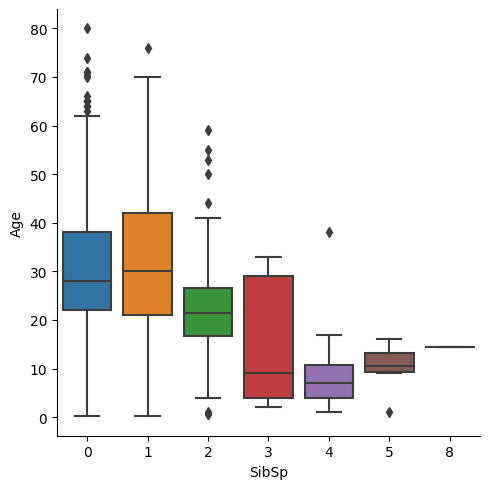

In [52]:
sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.catplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

<Axes: >

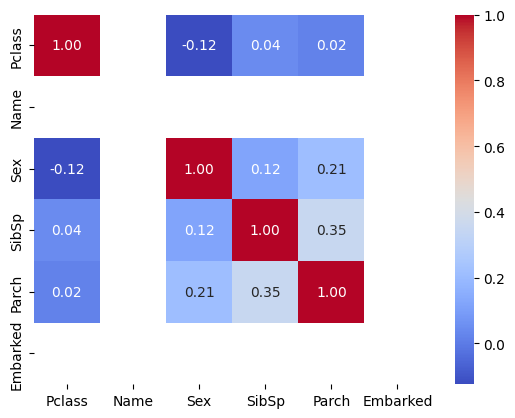

In [53]:
# Drop non-numeric columns and calculate the correlation
numeric_columns = combine.drop(['Survived', 'PassengerId', 'Age', 'Fare'], axis=1)
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

# Plot the heatmap of the correlation matrix
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm')


In [54]:
# Check number of missing ages 

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

In [55]:
# Loop through list and inpute missing ages

for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [56]:
# Make sure there is no more missing ages 

combine['Age'].isnull().sum()

0

Text(0.5, 1.0, 'Passenger Fare Distribution')

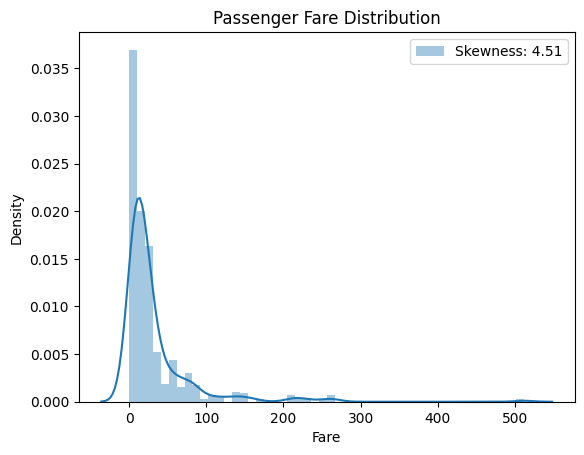

In [57]:
# Passenger fare distribution

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [58]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

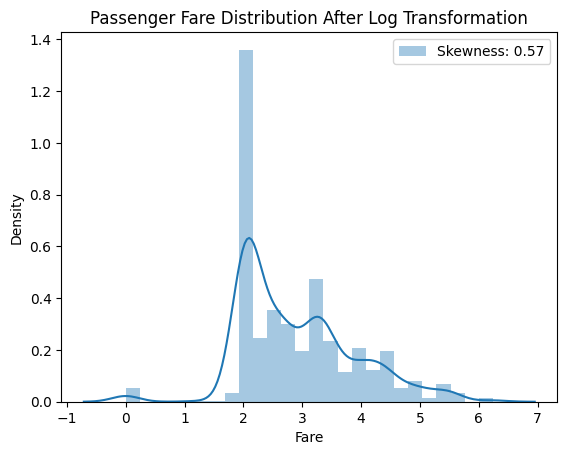

In [59]:
# Passenger fare distribution after log transformation

sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

In [60]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,S


In [61]:
# Get title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [62]:
# Value counts of Title

combine['Title'].value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [63]:
# Number of unique Title

combine['Title'].nunique()

18

In [64]:
# Simplify title

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady', 'Jonkheer', 'Don', 'Capt', 'the Countess',
                                             'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle','Mrs'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

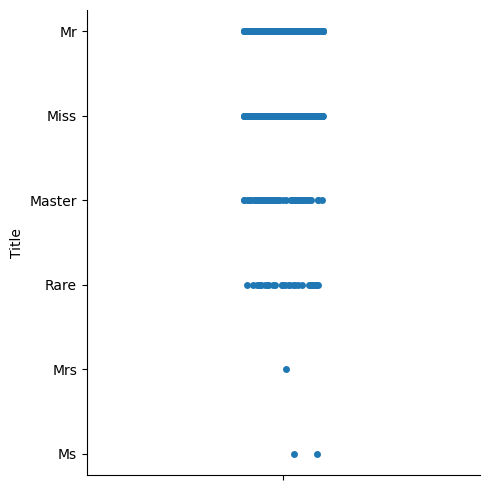

In [65]:
sns.catplot(combine['Title'])

In [66]:
# Mean of survival by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Title,Survived
3,Mrs,1.000000
4,Ms,1.000000
1,Miss,0.743421
0,Master,0.589744
5,Rare,0.347826
2,Mr,0.157895


Text(0.5, 1.0, 'Mean of survival by Title')

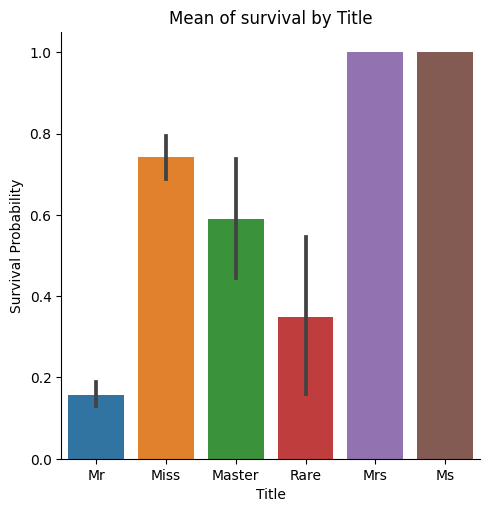

In [67]:
sns.catplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [68]:
# Drop name column

combine = combine.drop('Name', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Miss
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Miss
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


In [69]:
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [70]:
# Mean of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [71]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [72]:
# Mean of survival by IsAlone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [73]:
# Drop SibSp, Parch and FamilySize features from combine dataframe

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Miss,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Miss,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1


In [74]:
# Create age bands and compute mean of survival by age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by = 'AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [75]:
# Assign ordinals to each age band 

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034 , 'Age'] = 4

In [76]:
# Drop age band feature

combine = combine.drop('AgeBand', axis = 1)
# Age and Pclass data types 

combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [77]:
# Convert ordinal Age into integer

combine['Age'] = combine['Age'].astype('int')
combine['Age'].dtype


dtype('int32')

In [78]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


In [79]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Miss,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Miss,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [80]:
# Encode Title and Embarked feature

combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,4.266662,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,2.070022,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,3.972177,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,2.085672,1,6,False,False,True,False,False,False,False,False,True


In [81]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [82]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [83]:
# Convert Fare into integer

combine['Fare'] = combine['Fare'].astype('int')
# Drop FareBand feature

combine = combine.drop('FareBand', axis = 1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [84]:
# Separate training and test set from the combined dataframe

train = combine[:len(train)]
test = combine[len(train):]
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,2,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,3,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,4,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,5,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [85]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,1.0,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,1.0,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,1.0,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,0.0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [86]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,False,False,True,False,False,False,False,False,True
1,1,1,1,2,2,0,2,False,True,False,False,False,False,True,False,False
2,1,3,1,1,1,1,3,False,True,False,False,False,False,False,False,True
3,1,1,1,2,2,0,2,False,True,False,False,False,False,False,False,True
4,0,3,0,2,1,1,6,False,False,True,False,False,False,False,False,True


In [87]:
test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,1,6,False,False,True,False,False,False,False,True,False
882,893,NaN,3,1,2,1,0,6,False,True,False,False,False,False,False,False,True
883,894,NaN,2,0,3,1,1,6,False,False,True,False,False,False,False,True,False
884,895,NaN,3,0,1,1,1,3,False,False,True,False,False,False,False,False,True
885,896,NaN,3,1,1,1,0,3,False,True,False,False,False,False,False,False,True


In [88]:
# Drop passenger survived column from test set

test = test.drop('Survived', axis = 1)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Em_C,Em_Q,Em_S
881,892,3,0,2,1,1,6,False,False,True,False,False,False,False,True,False
882,893,3,1,2,1,0,6,False,True,False,False,False,False,False,False,True
883,894,2,0,3,1,1,6,False,False,True,False,False,False,False,True,False
884,895,3,0,1,1,1,3,False,False,True,False,False,False,False,False,True
885,896,3,1,1,1,0,3,False,True,False,False,False,False,False,False,True


In [89]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 15)
Y_train shape:  (881,)
X_test shape:  (418, 15)


In [90]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

In [91]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.31

In [92]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.11

In [93]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

61.63

In [94]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.77

In [95]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.14

In [96]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

79.68

In [97]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.13

In [98]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.13

In [101]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.00976
0:	learn: 0.6858616	total: 3.48ms	remaining: 3.48s
1:	learn: 0.6794489	total: 8.8ms	remaining: 4.39s
2:	learn: 0.6734253	total: 12ms	remaining: 3.99s
3:	learn: 0.6679846	total: 15.7ms	remaining: 3.92s
4:	learn: 0.6626666	total: 19.8ms	remaining: 3.95s
5:	learn: 0.6575581	total: 23.9ms	remaining: 3.95s
6:	learn: 0.6515583	total: 28ms	remaining: 3.97s
7:	learn: 0.6453888	total: 31.2ms	remaining: 3.87s
8:	learn: 0.6400033	total: 35.7ms	remaining: 3.93s
9:	learn: 0.6340809	total: 40.1ms	remaining: 3.97s
10:	learn: 0.6292482	total: 44.3ms	remaining: 3.99s
11:	learn: 0.6233883	total: 47.9ms	remaining: 3.95s
12:	learn: 0.6177923	total: 51.9ms	remaining: 3.94s
13:	learn: 0.6129961	total: 55.8ms	remaining: 3.93s
14:	learn: 0.6075451	total: 59.7ms	remaining: 3.92s
15:	learn: 0.6037752	total: 63.7ms	remaining: 3.92s
16:	learn: 0.5998291	total: 67.7ms	remaining: 3.92s
17:	learn: 0.5954977	total: 71.7ms	remaining: 3.91s
18:	learn: 0.5909803	total: 75.7ms	remaining: 3.91

In [102]:
acc_catboost

85.02

In [103]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,85.13
1,Decision Tree,85.13
2,CatBoost,85.02
3,KNN,84.11
4,Support Vector Machines,83.31
5,Logistic Regression,80.93
6,Linear SVC,80.14
7,Stochastic Gradient Decent,79.68
8,Perceptron,78.77
9,Naive Bayes,61.63


In [104]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [105]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6860947	total: 4.28ms	remaining: 4.28s
1:	learn: 0.6802154	total: 8.37ms	remaining: 4.17s
2:	learn: 0.6735760	total: 12.4ms	remaining: 4.13s
3:	learn: 0.6678713	total: 16.8ms	remaining: 4.19s
4:	learn: 0.6623104	total: 20.5ms	remaining: 4.08s
5:	learn: 0.6573463	total: 24.3ms	remaining: 4.03s
6:	learn: 0.6520895	total: 28ms	remaining: 3.97s
7:	learn: 0.6470688	total: 32ms	remaining: 3.96s
8:	learn: 0.6439155	total: 34.9ms	remaining: 3.84s
9:	learn: 0.6389356	total: 38.6ms	remaining: 3.82s
10:	learn: 0.6331751	total: 42.3ms	remaining: 3.8s
11:	learn: 0.6280368	total: 46ms	remaining: 3.78s
12:	learn: 0.6236099	total: 49.3ms	remaining: 3.74s
13:	learn: 0.6186777	total: 52.9ms	remaining: 3.73s
14:	learn: 0.6138725	total: 56.5ms	remaining: 3.71s
15:	learn: 0.6110885	total: 59.1ms	remaining: 3.63s
16:	learn: 0.6059912	total: 62.7ms	remaining: 3.63s
17:	learn: 0.6026544	total: 65.3ms	remaining: 3.56s
18:	learn: 0.6001507	total: 68.1ms	remaining: 3.52s

In [106]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [107]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.824042,0.043568,Support Vector Machines
1,0.816152,0.034175,KNN
2,0.808197,0.033718,CatBoost
3,0.801379,0.034449,Logistic Regression
4,0.796834,0.036020,Linear SVC
5,0.794574,0.025433,Random Forest
6,0.785495,0.020941,Decision Tree
7,0.732061,0.111711,Stochastic Gradient Descent
8,0.703767,0.124160,Perceptron
9,0.633414,0.044486,Gausian Naive Bayes


Text(0.5, 1.0, 'Cross Validation Scores')

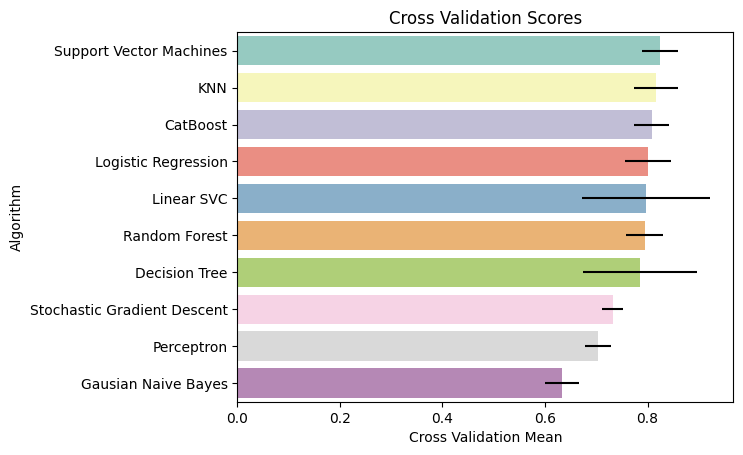

In [108]:
sns.barplot(x='Cross Validation Mean', y='Algorithm', data = cv_res ,order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

In [109]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, Y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.763 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.773 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.722 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.767 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.802 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.812 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.784 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.807 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.734 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [110]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=100, gamma=0.01)


In [111]:
svc = SVC(C = 100, gamma = 0.01, kernel = 'rbf')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.54

In [112]:
cross_val_score(svc, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0.8308605720122575

In [113]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [114]:
len(Y_pred)

418

In [115]:
ss.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [117]:
submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head(10)

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1
886,897,0
887,898,1
888,899,0
889,900,1
890,901,0


In [119]:
submission = pd.DataFrame({'PassengerId': pd.read_csv('Data/test.csv')['PassengerId'], 'Survived': Y_pred})
submission.to_csv('titanic_submission1.csv', index=False)
print("Output File Successfully created.")

Output File Successfully created.
